In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# For reproducible results
np.random.seed(0)

In [3]:
# Load the the csv file (BCa Wisconsin Diagnostic Data Set (Kaggle).csv)
BCa_address = '/Users/francybayona/Documents/DOC DIEGO/Python docs/Nanostic Project/BCa Wisconsin Diagnostic Data Set (Kaggle).csv'
df_BCa = pd.read_csv(BCa_address)
df_BCa.head(1)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,NaN


In [4]:
# drop columns that are not part of the analysis using the drop function
inputs = df_BCa.drop(['id', 'Unnamed: 32'],axis='columns')
inputs.head(1)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [5]:
# Use the function LabelEncoder for the column diagnosis
inputs['diagnosis'] = LabelEncoder().fit_transform(inputs['diagnosis'])
inputs.head(1)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [6]:
#Separate variables (x) from target (y) 
x = inputs.drop(['diagnosis'],axis='columns')
y = inputs.diagnosis

In [7]:
# Specify the number of folds for the outer cross validation
outer_cv_folds = 5

In [8]:
# Initialize probability variables
prob_train = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train = np.full(outer_cv_folds, np.nan)
aucs_test = np.full(outer_cv_folds, np.nan)

In [10]:
#Outer cross validation
cv_outer = StratifiedKFold(n_splits=outer_cv_folds)
ncv_idx = -1

In [11]:
#Design a for loop for a inner cross validation
for train_idx, test_idx in cv_outer.split(x, y):
    ncv_idx += 1
    train_data, test_data = x.iloc[train_idx], x.iloc[test_idx]
    train_target, test_target = y.iloc[train_idx], y.iloc[test_idx]
    XGBoost_model = XGBClassifier(objective = 'binary:logistic', # Add objective and metric to model initialization
                                  eval_metric = 'auc')
    
    # Find best XGBoost parameters
    cv_inner = StratifiedKFold(n_splits=3)   # split 3 times training for nested cross validation
    Parmt_XGBoost = {'n_estimators':[50, 100],
                     'max_depth':[3, 5],
                     'learning_rate':[0.01, 0.1, 0.3],
                     'colsample_bytree':[0.5, 1],
                     'gamma':[0],
                     }
    Parmt_model_XGBoost = GridSearchCV(estimator=XGBoost_model,
                                       param_grid=Parmt_XGBoost,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters = Parmt_model_XGBoost.best_params_
    # Set best parameters to XGBoost model
    XGBoost_model.set_params(**best_parameters)   
    
    # Train optimized XGBoost model on train data
    XGBoost_model.fit(train_data,train_target)
    
    # Train data results
    prob_train[train_idx, ncv_idx] = XGBoost_model.predict_proba(train_data)[:,1]
    aucs_train[ncv_idx] = metrics.roc_auc_score(train_target, prob_train[train_idx, ncv_idx])

    # Test data results
    prob_test[test_idx, ncv_idx] = XGBoost_model.predict_proba(test_data)[:,1]
    aucs_test[ncv_idx] = metrics.roc_auc_score(test_target, prob_test[test_idx, ncv_idx])

In [12]:
# Final test predictions in one column
prob_test_final = np.nanmean(prob_test, axis=1)

In [13]:
# AUC based on test predictions
auc_test_prob = metrics.roc_auc_score(y, prob_test_final)

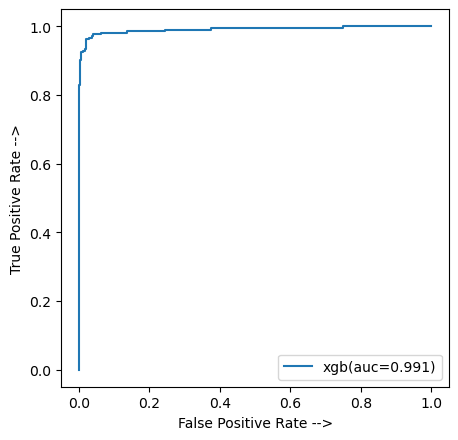

In [15]:
# Plot AUC
xgb_fpr, xgb_tpr, threshold = metrics.roc_curve(y, prob_test_final)
auc_xgb = metrics.auc(xgb_fpr, xgb_tpr)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label='xgb(auc=%0.3f)' % auc_xgb)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()